[array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [0, 1, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 1, 1]])]


<IPython.core.display.Javascript object>


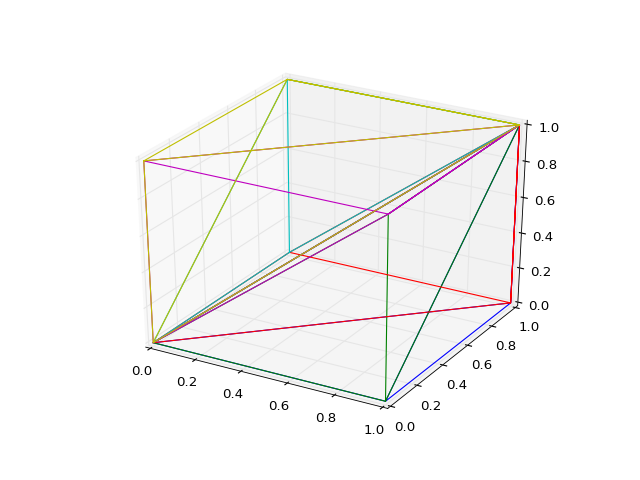

<IPython.core.display.Javascript object>


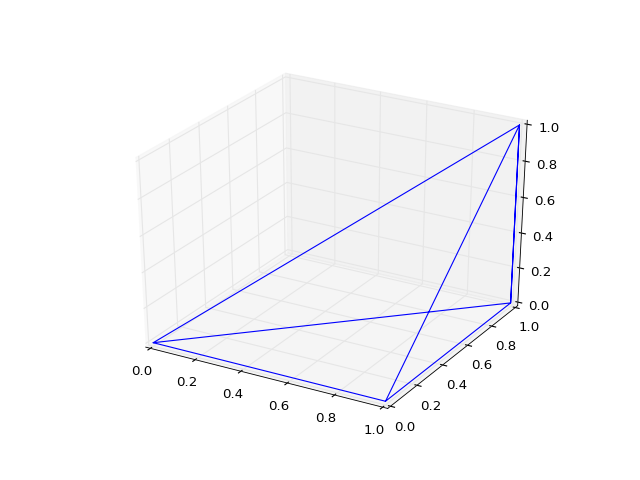

In [313]:
import logging
class Complex():
    """
    A class relating the vertexes of a hypercomplex of hypersimplices without
    physical storage by exploiting the symmetry of the simplicial powerset.
    """
    def __init__(self, dim=2):
        import numpy
        self.V = []
        self.S = []  # Face indexes, edges = 1 face
        self.I = []  # Index sets
        self.i_gen = [] 
        self.i_current = [] 
        for i in range(dim + 1):
            self.S.append([])
            self.I.append([])
            self.i_gen.append(self.index_gen())     
            self.i_current.append(0)  
            
        #self.I_V = numpy.linspace(0, dim**2)
        
        # Intiate first generation of vertices
        #V      
            
    def n_cube(self, dim, printout=False):
        """
        Generate the simplicial triangulation of the n cube
        containing 2**n vertices
        """
        import math
        import numpy

        permgroups = list(itertools.permutations(range(dim)))
        self.permgroups = permgroups
        # Build the D set feasible region to use for symmetery groups later:
        D = [[0, 1],]*dim  # Domain := hypercube
        D = numpy.array(D)

        C = []
        for tau in permgroups:  # n! simplices
            S = numpy.tile(D[:, 0], (dim + 1, 1))

            for i in range(dim):
                for j in range(dim):
                    S[i + 1] = S[i]  # (Needed since looping through i will use these)

                tau[i]
                S[i + 1][tau[i]] = D[tau[i], 1]

            #TODO: Loop and identify vertices
            C.append(S)
            
        if printout:
            self.print_complex(permgroups, C)
                
        return C
    
    def initial_vertices(self, C, dim):
        # Fit n_cube result into vertices
        for S in C:
            self.generate_simplex(S, k = dim-1)
            for i, x in enumerate(S):        
                if i < dim:
                    self.generate_vertex(x)            
            # We want the last index of the initial cube to have
            # the last index in the initial generation

        self.generate_vertex(S[-1])    
        return
    
    
    def index_simplices(self, C):
        # Construct the index simplices
        Ci = []
        for i, S in enumerate(C):
            Ci.append([])  # = Si
            for x in S:        
                for j, v in enumerate(HC.V):
                    if (x == v).all():
                        Ci[i].append(j)

        return Ci             

    def index_complex(self, C):
        """
        Generate unique indices for every vertex in a set of simplices S
        NOTE: Used for dev/visualization only, highly inefficient
        """
        for S in C:
            for x in S:
                print(x)
            #print(s)
        
        return
        
    def generate_vertex(self, x):
        """
        x: vector of cartesian coordinates
        """
        
        import numpy as np
        if any((x == v).all() for v in self.V):
            return  # return if vertex is found without generating
        
        
        #if (x == self.V).all(np.arange(x - self.V, x)).any():
        #if (x not in self.V).any():
        self.V.append(x)
        self.i_current[0] = next(self.i_gen[0])
        logging.info('self.i_current[0] = {}'.format(self.i_current[0]))
        self.I[0].append(self.i_current[0])

        
    def generate_simplex(self, V_i, k=1):
        """
        V_i: Tuple containing the indexes of vertices to connect
        """
        self.S[k].append(V_i)
        self.i_current[k] = next(self.i_gen[k])  
        logging.info('self.i_current[k] = {}'.format(self.i_current[k]))
        self.I[k].append(self.i_current[k])
        
    def destroy_simplex(self, ind, k=1):
        """
        Delete faces from lists to free up memory
        """
        del self.S[k][ind]
            
    def index_gen(self):
        ind = 0
        while True:
            yield ind
            ind += 1
            
    # incidence arrays
    
    # plots and prints
    def plot_vertexes(self, V):
        return
    
    def plot_graph(self):
        from matplotlib import pyplot
        pyplot.figure()
        for v in HC.V:
            pyplot.plot([v[0]], [v[1]], 'o')

        for f in HC.S[1]:
            #print(HC.V[f[0]], HC.V[f[1]])
            pyplot.plot([HC.V[f[0]][0], HC.V[f[1]][0]],
                          [HC.V[f[0]][1], HC.V[f[1]][1]], 'r-')

        pyplot.ylim([-1e-2, 1+1e-2])
        pyplot.xlim([-1e-2, 1+1e-2])
        pyplot.show()
        return
       
    def plot_complex(self, C):
        """
        Here C is the LIST of simplexes S in the 
        2 or 3 dimensional complex 
        
        To plot a single simplex S in a set C, use ex. [C[0]]
        """
        from matplotlib import pyplot      
        
        dims = len(C[0][0])
        if dims == 2:
            pyplot.figure()
            for s in C:
                xlines = []
                ylines = []
                for v in s:
                    pyplot.plot([v[0]], [v[1]], 'o')
                    xlines.append(v[0])
                    ylines.append(v[1])
                    
                xlines.append(s[0][0])
                ylines.append(s[0][1])
                pyplot.plot(xlines, ylines)

            pyplot.ylim([-1e-2, 1+1e-2])
            pyplot.xlim([-1e-2, 1+1e-2])
            pyplot.show()
        
        elif dims == 3: 
            from mpl_toolkits.mplot3d import Axes3D
            fig = pyplot.figure()
            ax = fig.add_subplot(111, projection='3d')

            for s in C:
                x = []
                y = []
                z = []
                for v in range(4):
                    x.append(s[v, 0])
                    y.append(s[v, 1])
                    z.append(s[v, 2])

                # Lines from first with thrid vertex
                x.append(s[0][0])
                y.append(s[0][1])
                z.append(s[0][2])
                x.append(s[2][0])
                y.append(s[2][1])
                z.append(s[2][2])
                # Lines from last to second vertex
                x.append(s[3][0])
                y.append(s[3][1])
                z.append(s[3][2])
                x.append(s[1][0])
                y.append(s[1][1])
                z.append(s[1][2])

                ax.plot(x, y, z, label='simplex')
        else:
            print("dimension higher than 3 or wrong S format")
        return

    def print_complex(self, permgroups, C):
        for i, tau in enumerate(permgroups):
            print('Tau: {}'.format(tau))
            print('Simpex {}:'.format(i))
            print(C[i])
            
        return
    
    def print_complex_set(self):
        print('Index set I = {}'.format(self.I))
        print('Vertices V = {}'.format(self.V))
        print('Simplices S = {}'.format(self.S))
            
HC = Complex()
HC.I

#HC.index_gen()
#index = HC.index_gen()
#next(HC.i_gen[0]), next(HC.i_gen[0]), next(HC.i_gen[1]), next(HC.i_gen[0]), next(HC.i_gen[1])

# Example intial complex generation in 3 dimensions
C = HC.n_cube(3, printout=False)
print(C)
HC.plot_complex(C)
HC.plot_complex([C[0]])

In [317]:
HC = Complex()
HC.I
import numpy
HC.generate_vertex(numpy.array([0, 0]))  # 0
HC.generate_vertex(numpy.array([0, 1]))  # 1
HC.generate_vertex(numpy.array([1, 0]))  # 2
HC.generate_vertex(numpy.array([1, 1]))  # 3
#HC.generate_vertex([0.5, 0.5])

# Generate edges
HC.generate_simplex([0, 1], k=1)
HC.generate_simplex([0, 2], k=1)
HC.generate_simplex([0, 3], k=1)
HC.generate_simplex([1, 3], k=1)
HC.generate_simplex([2, 3], k=1)
#@HC.generate_face([3, 1], k=1)

# Generate k=2 faces
HC.generate_simplex([0, 1, 3], k=2)
HC.generate_simplex([0, 2, 3], k=2)

# Print resulting structure
HC.I, HC.V, HC.S


([[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]],
 [array([0, 0]), array([0, 1]), array([1, 0]), array([1, 1])],
 [[], [[0, 1], [0, 2], [0, 3], [1, 3], [2, 3]], [[0, 1, 3], [0, 2, 3]]])

<IPython.core.display.Javascript object>


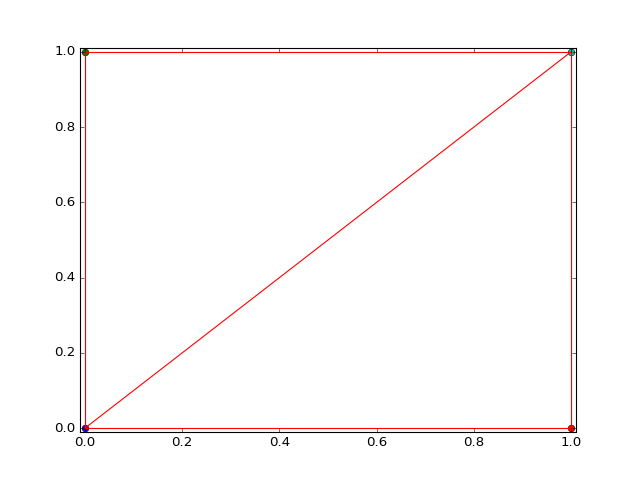

In [318]:
HC.plot_graph()

Initial complex generation
==

In [332]:
# Find unique vertices
for dim in range(1, 5):
    #dim = 4
    print("="*100)
    print('='*20)
    print('Dimension = {}'.format(dim))
    print('='*20)
    
    HC = Complex(dim)
    C = HC.n_cube(dim, printout=False)


    HC.initial_vertices(C, dim)

    # Construct the index simplices
    Ci = HC.index_simplices(C)

    print(HC.V)
    print(HC.I)
    print(HC.S)
    HC.print_complex(HC.permgroups, C)
    HC.print_complex(HC.permgroups, Ci)
    print("="*100)


Dimension = 1
[array([0]), array([1])]
[[0, 1, 2], []]
[[array([[0],
       [1]])], []]
Tau: (0,)
Simpex 0:
[[0]
 [1]]
Tau: (0,)
Simpex 0:
[0, 1]
Dimension = 2
[array([0, 0]), array([1, 0]), array([0, 1]), array([1, 1])]
[[0, 1, 2, 3], [0, 1], []]
[[], [array([[0, 0],
       [1, 0],
       [1, 1]]), array([[0, 0],
       [0, 1],
       [1, 1]])], []]
Tau: (0, 1)
Simpex 0:
[[0 0]
 [1 0]
 [1 1]]
Tau: (1, 0)
Simpex 1:
[[0 0]
 [0 1]
 [1 1]]
Tau: (0, 1)
Simpex 0:
[0, 1, 3]
Tau: (1, 0)
Simpex 1:
[0, 2, 3]
Dimension = 3
[array([0, 0, 0]), array([1, 0, 0]), array([1, 1, 0]), array([1, 0, 1]), array([0, 1, 0]), array([0, 1, 1]), array([0, 0, 1]), array([1, 1, 1])]
[[0, 1, 2, 3, 4, 5, 6, 7], [], [0, 1, 2, 3, 4, 5], []]
[[], [], [array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [0, 1,

Dev work
==

In [296]:
# Generate intial simplex
HC = Complex(dim)
C = HC.n_cube(dim, printout=False)
HC.initial_vertices(C, dim)
Ci = HC.index_simplices(C)
    

# Split the simplices by sampling the longest edge


#For the first 
for S in C: # For every simplex in C:
    HC.generate_vertex((S[0] + S[-1])/2.0)
    print((S[0] + S[-1])/2.0)
    

[ 0.5  0.5  0.5]
[ 0.5  0.5  0.5]
[ 0.5  0.5  0.5]
[ 0.5  0.5  0.5]
[ 0.5  0.5  0.5]
[ 0.5  0.5  0.5]


In [303]:
HC.destroy_simplex(ind=0, k=dim-1)
#HC = Complex()
#C = HC.n_cube(dim, printout=False)
HC.S

IndexError: list assignment index out of range